In [195]:
import numpy as np
import random
import copy
from matplotlib import pyplot as plt

In [2]:
def rotate_mat(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

## Setup joints

In [224]:
class Joint:
    def __init__(self, rad, length):
        self.angle = rad
        self.length = length
        
    def __str__(self):
        return 'angle = ' + str(np.degrees(self.angle)) + '°, length = %f' % self.length
    
    def __len__(self):
        return self.length

In [225]:
MAX_JOINT_LENGTH = 10
N_JOINTS = 5

In [226]:
random.seed(0)

joints = []

for i in range(N_JOINTS):
    joints.append(Joint(random.random() * 2 * np.pi, random.random() * MAX_JOINT_LENGTH))

In [227]:
for joint in joints:
    print(joint)

angle = 303.99186654901735°, length = 7.579544
angle = 151.40576909910422°, length = 2.589168
angle = 184.05889969269907°, length = 4.049341
angle = 282.1674920525181°, length = 3.033127
angle = 171.5749034948481°, length = 5.833820


In [244]:
def draw_joints(joints, target=None):
    end_effector = np.zeros((2,))
    
    pivots_x = [0]
    pivots_y = [0]
    for i, joint in enumerate(joints):
        end_effector += np.dot(rotate_mat(joint.angle), np.array([1,0])) * joint.length
        pivots_x.append(end_effector[0])
        pivots_y.append(end_effector[1])
        
    plt.plot(
        pivots_x,
        pivots_y,
        marker='o',
        markerfacecolor='r',
        color='black',
        linestyle='solid',
        linewidth=0.3
    )
    plt.plot(0, 0, 'bo')
    
    if target is not None:
        plt.vlines(target[0], -15, 15, colors='g', linewidth=0.3)
        plt.hlines(target[1], -15, 15, colors='g', linewidth=0.3)
    
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.show()

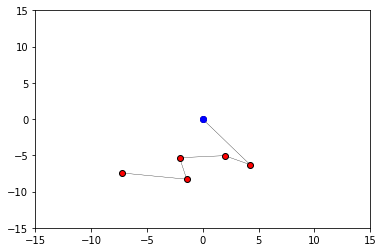

In [245]:
draw_joints(joints)

## Jacobian Pseudoinverse

In [230]:
# h = DELTA value for partial derivative calculation
DELTA = 1e-6

# Error tolerance (epsilon)
TOLERANCE = 1e-3

# Maximum number of iterations
MAX_ITERATIONS = 100

In [231]:
def partial_derivative(f1, f0, h=DELTA):
    return (f1 - f0) / h

In [232]:
def jacobian(f, x, h=DELTA, image_dim=2):
    J = np.empty((image_dim, len(x)))
    for k in range(J.shape[1]):
        hv = np.zeros(x.shape)
        hv[k] = h
        fxh = f(x + hv)
        fx = f(x)
        for i in range(J.shape[0]):
            J[i,k] = partial_derivative(fxh[i], fx[i], h)
    return J

In [236]:
def f_from_joints(joints, x):
    R = np.zeros((2,2))
    for i, joint in enumerate(joints):
        R += joint.length * rotate_mat(x[i])
    return R.dot(np.array([1,0]))

In [237]:
def loss(end_effector, target):
    dv = target - end_effector
    return np.sqrt(dv.dot(dv))

In [249]:
target = np.array([-13,-12])

x0 = np.empty((len(joints),))
for i, joint in enumerate(joints):
    x0[i] = joint.angle
    
x = x0.copy()

for i in range(MAX_ITERATIONS + 1):
    end_effector = f_from_joints(joints, x)
    L = loss(end_effector, target)
    print('#%d:' % i, L)
    if L <= TOLERANCE:
        break
    diff = target - end_effector
    dx = np.linalg.pinv(jacobian(lambda x : f_from_joints(joints, x), x)).dot(diff)
    x += dx

#0: 7.371494255715373
#1: 2.0280741088494385
#2: 0.15852298665822945
#3: 0.001329169050521289
#4: 8.206209637604523e-08


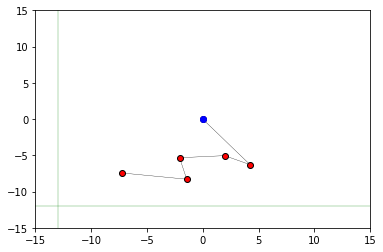

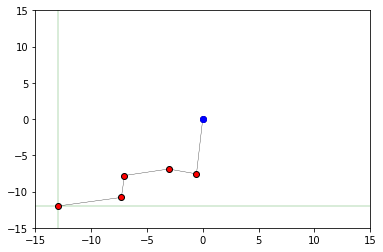

In [250]:
solved_joints = copy.deepcopy(joints)
for i in range(len(solved_joints)):
    solved_joints[i].angle = x[i]
    
draw_joints(joints, target)
draw_joints(solved_joints, target)